<left>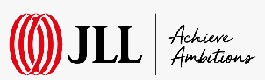</left>

## House View -  Office Market

#### Usage Guide: 

0. VERY IMPORTANT!! MAKE THE DATABANK STRUCTURE REMAINS THE SAME EVERY QUARTER!!

1. CHECK THE CONFIGURATION CELL BELOW AND CHANGE "FILE OUTPUT NAME" ,  "DATABANK TO BE LOADED"(FX. Q3 2021 DATABANK .XLX)

2. LOAD ALL THE DATABASES AND CONVERT THEM IN DICTIONARIES

3. CHECK THAT ALL THE SERIES MATCH THE TIME PERIOD


#### NOTE

- Make sure the dictionary keys are the same! don't change that!
- Marke sure the YTD Sales Adjusted Price Column is all numbers not string


#### Help Files :

- https://python-pptx.readthedocs.io/en/latest/user/placeholders-using.html
- https://python-pptx.readthedocs.io/en/latest/user/charts.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html

#### Configuration:

In [1]:
# Config file
#Canada CM Databank - Q3 2021 - WIP v12.xlsx
#Canada CM Databank - Q2 2021_Final_6_V2.xlsx
Databank_name='Canada CM Databank - Q3 2021 - NEW3.xlsx'
file_output_name="Q3_2021_Office.pptx"

#### Loading and Formatting the Databank: 

In [2]:
#Import Packages
#Using the geo_env environment
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE
from pptx.dml.color import RGBColor
from pptx.util import Inches, Pt
from pptx.enum.dml import MSO_THEME_COLOR
import numpy as np
import pandas as pd
from pptx.chart.data import CategoryChartData
from pptx.enum.chart import XL_CHART_TYPE
from pptx.chart.data import ChartData
import numpy as np 
import datetime


from pptx.dml.chtfmt import ChartFormat
from pptx.enum.chart import (
    XL_AXIS_CROSSES,
    XL_CATEGORY_TYPE,
    XL_TICK_LABEL_POSITION,
    XL_TICK_MARK,
    XL_LEGEND_POSITION
)
from pptx.oxml.ns import qn
from pptx.oxml.simpletypes import ST_Orientation
from pptx.shared import ElementProxy
from pptx.text.text import Font, TextFrame
from pptx.util import lazyproperty

In [3]:
#Helper Functions:

#1. Function that creates panel
def create_panel(capital_data):
    #Selecting the initial columns for future processing, leave the 6 column out.If a column is empty its erased...problem
    f1 = capital_data.iloc[:, 0:6] 
    #Creating dates out of column names
    Dates_Quarters=capital_data.columns[6:len(capital_data.columns)]
    Dates = pd.to_datetime([f'{x[-4:]}{x[:2]}' for x in Dates_Quarters])
    #Create a Pandas Dataframe with the Dates and size of the new panel
    Dates_pd=pd.DataFrame(Dates)
    Dates_pd.columns=['Dates']
    Dates_column=pd.concat([Dates_pd]*len(f1)).reset_index(drop=True)+ pd.DateOffset(months=2)
    #Create a panel with the first 6 variables, its very imported to sorted by index so I can flip the valus
    Panel=pd.concat([f1]*len(Dates_pd)).sort_index(axis=0)
    Panel=Panel.reset_index(drop=True)
    #Values of the Statistics
    List_of_Rows=[]
    Series=capital_data.iloc[:, 6:]
    for i in range(0,len(Series)):
        list_Series=Series.loc[i].reset_index(drop=True)
        frame=pd.DataFrame(list_Series)
        frame.columns=['Value']
        List_of_Rows.append(frame)
    Values=pd.concat(List_of_Rows)
    Values=Values.reset_index(drop=True)
    # Now we can Concatenate the Dates + Panel + Values
    Result = pd.concat([Dates_column,Panel, Values], axis=1)
    return Result

#2. Separate all the series in the panel and creates a dictionary
def create_series_dictionary(my_panel):
    #Getting Unique Series
    Unique_Series=my_panel.groupby(['Sector','Parameter','Sub-Type','Market','Class']).size().reset_index()
    Unique_Series['Labels']=Unique_Series['Sector'] + "_"+ Unique_Series['Parameter'] + "_" + Unique_Series['Sub-Type'] + "_" + Unique_Series['Market']  + Unique_Series['Class']
    #Dictionary with all the data
    My_Library=dict()
    #Addng the Dates to the Dictionary
    Dates=my_panel['Dates'].dt.strftime("%m/%d/%Y")
    Dates=Dates.unique()   
    My_Library['Dates']=Dates
    #Adding the rest of the series:
    for index,series in enumerate(Unique_Series['Labels']):
        Data=my_panel[(my_panel['Sector'] == Unique_Series['Sector'][index]) & (my_panel['Parameter'] ==  Unique_Series['Parameter'][index])  & (my_panel['Sub-Type'] == Unique_Series['Sub-Type'][index]) & (my_panel['Market'] == Unique_Series['Market'][index]) & (my_panel['Class'] == Unique_Series['Class'][index])]
        Data=Data['Value'].to_numpy()
        My_Library[str(series)]=Data
    return My_Library

#Filling the Array's NAN with value
def fill_array_with_near_value(arr):
    ind = np.where(~np.isnan(arr))[0]
    first, last = ind[0], ind[-1]
    arr[:first] = arr[first]
    arr[last + 1:] = arr[last]
    return arr

#Function that Creates table in the pptx from a pandas data frame (Table_Sorted_2) and slide.placeholder of the 'table' kind
def create_pptx_table(Table_Sorted_2,table_1,font_size):
    #Creates Rows and Columns of the Talbe, There is plus 1 row to account for the column headers
    columns=Table_Sorted_2.shape[1]
    rows=Table_Sorted_2.shape[0]+1
    shape=table_1.insert_table(rows=rows, cols=columns)
    My_table=shape.table
    #Fill up the column names
    for index,column_name in enumerate(Table_Sorted_2.columns):
        cell= My_table.cell(0, index)
        cell.text=column_name
        cell.text_frame.paragraphs[0].font.size=Pt(font_size)
    #Fill the table with the cell data
    for row in range(1,rows):
        for column in range(columns):
            cell = My_table.cell(row, column)
            #The table actual dataset had one only 10 rows.
            cell.text =str(Table_Sorted_2.iloc[row-1,column])
            cell.text_frame.paragraphs[0].font.size=Pt(font_size)



In [4]:
#Loading Databank "Valuation Parameters" and Creating Panel
capital_data=pd.read_excel(open(Databank_name,'rb'),sheet_name='Valuation Parameters', header=1,index_col= False,engine = 'openpyxl')

#Creating your Panel, always remeber that there is no empty columns on the
my_panel=create_panel(capital_data)

#Put all the series into a dictionary for use
dictionary_with_panel=create_series_dictionary(my_panel)

#Quarter_Dates
Dates_Quarters=my_panel['Dates'].dt.to_period('Q').unique
Dates_Quarters=capital_data.columns[6:len(capital_data.columns)]



In [5]:
#Loading Databank "Hist. Inv. Volumes" and Data Structures Necesary
list_inv_volumes=pd.read_excel(open(Databank_name,'rb'),sheet_name='Hist. Inv. Volumes', header=0,index_col= False,engine = 'openpyxl')

#Dictionary For Access to Dates
Dates_Inv_volumes=list_inv_volumes.columns[2:]
  
# Series Data for Charts, you can use the other one to create pivot tables
Labels=list_inv_volumes['Market']+'_'+list_inv_volumes['Asset Class']
new_col_names=list(Labels)
f1 = list_inv_volumes.iloc[:, 2:].T
f2=f1.to_dict('series')
new_dict=dict()
for i in f2.keys():
    new_dict[new_col_names[i]]=f2[i]

new_dict.keys()

dict_keys(['Toronto_Multifamily', 'Toronto_Land', 'Toronto_Hotel', 'Toronto_Industrial', 'Toronto_Office', 'Toronto_Retail', 'Toronto_Alternative Assets', 'Toronto_Total', 'Montreal_Multifamily', 'Montreal_Land', 'Montreal_Hotel', 'Montreal_Industrial', 'Montreal_Office', 'Montreal_Retail', 'Montreal_Alternative Assets', 'Montreal_Total', 'Vancouver_Multifamily', 'Vancouver_Land', 'Vancouver_Hotel', 'Vancouver_Industrial', 'Vancouver_Office', 'Vancouver_Retail', 'Vancouver_Alternative Assets', 'Vancouver_Total', 'Ottawa_Multifamily', 'Ottawa_Land', 'Ottawa_Hotel', 'Ottawa_Industrial', 'Ottawa_Office', 'Ottawa_Retail', 'Ottawa_Alternative Assets', 'Ottawa_Total', 'Calgary_Multifamily', 'Calgary_Land', 'Calgary_Hotel', 'Calgary_Industrial', 'Calgary_Office', 'Calgary_Retail', 'Calgary_Alternative Assets', 'Calgary_Total', 'Edmonton_Multifamily', 'Edmonton_Land', 'Edmonton_Hotel', 'Edmonton_Industrial', 'Edmonton_Office', 'Edmonton_Retail', 'Edmonton_Alternative Assets', 'Edmonton_Total',

In [6]:
# Loading Databank "Bonds, IRs, Indexes, & MSCI"
Financial_Data=pd.read_excel(open(Databank_name,'rb'),sheet_name='Bonds, IRs, Indexes, & MSCI', header=1,index_col= False,engine = 'openpyxl')

#Dictionary For Access to Dates
Dates_Inv_volumes=list_inv_volumes.columns[2:]
  
# Series Data for Charts, you can use the other one to create pivot tables
Labels=Financial_Data['Vehicle']+'_'+Financial_Data['Type']+'_'+Financial_Data['Geography']+'_'+Financial_Data['Sector']+'_'+Financial_Data['Metric']+'_'+Financial_Data['Source']
new_col_names=list(Labels)
f1 = Financial_Data.iloc[:, 6:].T
f2=f1.to_dict('series')
Financial_Data_dict=dict()
for i in f2.keys():
    Financial_Data_dict[new_col_names[i]]=f2[i]

Financial_Data_dict.keys()



dict_keys(['Canada 1 Year Treasury Bill Yield - Bank of Canada 1 year bond yield_Bond_National_Bond_Interest Rate_Bank of Canada - Y Charts', 'Canada 10 Year Benchmark Bond Yield -Bank of Canada 10 year bond yield_Bond_National_Bond_Interest Rate_Bank of Canada - Y Charts', 'Canada 2 Year Benchmark Bond Yield - Bank of Canada 2 year bond yield_Bond_National_Bond_Interest Rate_Bank of Canada - Y Charts', 'Canada 5 Year Benchmark Bond Yield - Bank of Canada 5 year bond yield_Bond_National_Bond_Interest Rate_Bank of Canada - Y Charts', 'Canada Target Overnight Rate - Bank of Canada Overnight Interest Rate_Interest Rate_National_Interest Rate_Interest Rate_Bank of Canada - Y Charts', 'Bank of Canada Prime Lending Rate_Interest Rate_National_Interest Rate_Interest Rate_Bank of Canada - Y Charts', 'CMHC_Interest Rate_National_Mortgage_Interest Rate_Bank of Canada', 'Commercial Mortgage Rate - 10 Yr_Interest Rate_National_Mortgage_Interest Rate_Bank of Canada', 'Commercial Mortgage Rate - 5 Y

In [7]:
#Loading Databank "YTD Sales Data" 
Sales_Data=pd.read_excel(open(Databank_name,'rb'),sheet_name='Sales Comps - YTD', header=0,engine = 'openpyxl')
Sales_Data_Tables=Sales_Data.filter(items=['Quarter','Sector','Transaction Name', 'Market ','Purchaser 1/ Purchaser 2/ Purchaser 3','Vendor 1/ Vendor 2/ Vendor 3','Adjusted Sale Price','Floor Area Acquired','Price PSF (Built Commercial)'])
Sales_Data_Tables_Multifamily=Sales_Data.filter(items=['Quarter','Sector','Transaction Name', 'Market ','Purchaser 1/ Purchaser 2/ Purchaser 3','Vendor 1/ Vendor 2/ Vendor 3','Adjusted Sale Price','Number of Units','Price per Unit (MF)'])
Sales_Data_Tables_Land=Sales_Data.filter(items=['Quarter','Sector','Transaction Name', 'Market ','Purchaser 1/ Purchaser 2/ Purchaser 3','Vendor 1/ Vendor 2/ Vendor 3','Adjusted Sale Price','Land Area','Price Per Acre (Land)'])

#Sales Data Tables Sorted
Table_Sorted=Sales_Data_Tables.sort_values(by=['Adjusted Sale Price'], ascending=False)
Table_Sorted_Multifamily=Sales_Data_Tables_Multifamily.sort_values(by=['Adjusted Sale Price'], ascending=False)
Table_Sorted_Land=Sales_Data_Tables_Multifamily.sort_values(by=['Adjusted Sale Price'], ascending=False)


In [8]:
#Variables  from "Valuation Parameters"
dictionary_with_panel.keys()

dict_keys(['Dates', 'Industrial_Average Net Rent_Multi Tenant_CalgaryOverall', 'Industrial_Average Net Rent_Multi Tenant_EdmontonOverall', 'Industrial_Average Net Rent_Multi Tenant_MontrealOverall', 'Industrial_Average Net Rent_Multi Tenant_National AverageOverall', 'Industrial_Average Net Rent_Multi Tenant_Ottawa-GatineauOverall', 'Industrial_Average Net Rent_Multi Tenant_TorontoOverall', 'Industrial_Average Net Rent_Multi Tenant_VancouverOverall', 'Industrial_Average Net Rent_Overall_CalgaryOverall', 'Industrial_Average Net Rent_Overall_EdmontonOverall', 'Industrial_Average Net Rent_Overall_MontrealOverall', 'Industrial_Average Net Rent_Overall_National AverageOverall', 'Industrial_Average Net Rent_Overall_Ottawa-GatineauOverall', 'Industrial_Average Net Rent_Overall_TorontoOverall', 'Industrial_Average Net Rent_Overall_VancouverOverall', 'Industrial_Average Net Rent_Overall_WinnipegOverall', 'Industrial_Average Net Rent_Single Tenant_CalgaryOverall', 'Industrial_Average Net Rent_Sin

#### Creating Presentation :

In [9]:
#Using the Design of House View--Template
#1. Open Presentation:
prs=Presentation('Canadian Capital Markets House View - Q3 2021.pptx')

#### SLIDE # 1 - SALES VOLUME WITH LARGEST TRANSACTIONS - CHECKED


In [10]:
#Select Template
lyt=prs.slide_layouts[0]
slide=prs.slides.add_slide(lyt)

#Look at placeholders in a slide
#for shape in slide.placeholders:
#     print('%d %s' % (shape.placeholder_format.idx, shape.name))
        
#Save Slide Place Holders
title_1,text_2,chart_1,table_1= slide.placeholders  

# Slide - Title
title=slide.shapes.title
title.text="Office - Top 10 Transactions YTD 2021"

##############################################################################
#Insert - Table of Top 10 Transactions
#Loading transactions and filtering the data I aneed to put into the table
Table_Sorted_2= Table_Sorted[Table_Sorted['Sector']=='Office'].head(n=10)
Table_Sorted_2=Table_Sorted_2.iloc[:, 2:]
Table_Sorted_2.reset_index(drop=True, inplace=True)
create_pptx_table(Table_Sorted_2,table_1,font_size=7)

##############################################################################
#Insert - Stacked Column of Office Investment by Market YTDchart_data = CategoryChartData()
chart_data = CategoryChartData()
chart_data.categories = Dates_Inv_volumes
chart_data.add_series('Toronto',new_dict['Toronto_Office']/1000000000)
chart_data.add_series('Vancouver',new_dict['Vancouver_Office']/1000000000)
chart_data.add_series('Ottawa',new_dict['Ottawa_Office']/1000000000)
chart_data.add_series('Calgary',new_dict['Calgary_Office']/1000000000)
chart_data.add_series('Edmonton',new_dict['Edmonton_Office']/1000000000)
chart_data.add_series('Montreal',new_dict['Montreal_Office']/1000000000)
#chart_data.add_series('SWO',new_dict['SWO_Office'])
graphic_frame=chart_1.insert_chart(XL_CHART_TYPE.COLUMN_STACKED, chart_data)
Actual_graph=graphic_frame.chart

#Global Font Size, Graph
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"

#Chart title
Actual_graph.chart_title.text_frame.text='Historical  Investment Voluments by City YTD 2021'                                                                                             
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)

#Y Axix
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="Total Investment $B"
Actual_graph.value_axis.has_major_gridlines=False
Actual_graph.value_axis.major_tick_mark
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '"$"#,##'

#Legend
Actual_graph.has_legend=True
Actual_graph.legend.position=XL_LEGEND_POSITION.TOP


#Formatting Ticks
Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE 
Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE 


#### SLIDE # 2 - INVESTMENT VOLUME- CHECKED

In [11]:
#Select Template
lyt=prs.slide_layouts[1]
slide=prs.slides.add_slide(lyt)

#Look at placeholders in a slide
#for shape in slide.placeholders:
#     print('%d %s' % (shape.placeholder_format.idx, shape.name))
        
#Save Slide Place Holders
title_1,text_1,chart_1= slide.placeholders 

# Slide - Title
title=slide.shapes.title
title.text="Office - Investment Volumens YTD 2021"
        
#Insert - Ranking Investment Volumens
Table_Sorted_2= Table_Sorted[Table_Sorted['Sector']=='Office']  
table = pd.pivot_table(Table_Sorted_2,index=['Market '],values=['Adjusted Sale Price'], aggfunc=np.sum)
table2 = pd.pivot_table(Table_Sorted_2,index=['Market '],values=['Quarter'], aggfunc=np.count_nonzero)
table3= pd.concat([table, table2], axis=1)
table3=table3.sort_values(by=['Adjusted Sale Price'], ascending=True)  

#Testing - Chart Ranking
chart_data = CategoryChartData()
chart_data.categories = list(table3.index)
chart_data.add_series('Investment Volumes', table3['Adjusted Sale Price']/100000000)
graphic_frame=chart_1.insert_chart(XL_CHART_TYPE.BAR_CLUSTERED, chart_data)
Actual_graph=graphic_frame.chart

#Chart title
Actual_graph.chart_title.text_frame.text='Investment Volumens YTD 2021'                                                                                             
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)

#Global Font Size, Graph
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"

#X Axix
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="Total Investment $B"
Actual_graph.value_axis.has_major_gridlines=False
Actual_graph.value_axis.major_tick_mark
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '"$"#,##'


#### SLIDE # 3 OFFICE PRICE PER SQUARE FOOT

In [12]:
#Select Template
#Using data fro YTD requires that all observations in PSF are Numbers not Strings! Not a combination of int, str and floats
lyt=prs.slide_layouts[2]
slide=prs.slides.add_slide(lyt)

#Look at placeholders in a slide
#for shape in slide.placeholders:
#     print('%d %s' % (shape.placeholder_format.idx, shape.name))

title_1,text_1,chart_1,chart_2= slide.placeholders

# Slide - Title
title=slide.shapes.title
title.text="Office - Price per Square Foot (PSF)"


#Chart ALTUS PSF DATA - This Works fine
chart_data = CategoryChartData()
chart_data.categories=  list(Dates_Quarters)
chart_data.add_series('Calgary',    fill_array_with_near_value(dictionary_with_panel['Office_Avg. Sale Price PSF_Downtown _CalgaryAA']))
chart_data.add_series('Edmonton',    fill_array_with_near_value(dictionary_with_panel['Office_Avg. Sale Price PSF_Downtown _EdmontonAA']))
chart_data.add_series('Vancouver',  fill_array_with_near_value(dictionary_with_panel['Office_Avg. Sale Price PSF_Downtown _VancouverAA']))
chart_data.add_series('Montreal',  fill_array_with_near_value(dictionary_with_panel['Office_Avg. Sale Price PSF_Downtown _MontrealAA']))
chart_data.add_series('Toronto',  fill_array_with_near_value(dictionary_with_panel['Office_Avg. Sale Price PSF_Downtown _TorontoAA']))
chart_data.add_series('Ottawa',  fill_array_with_near_value(dictionary_with_panel['Office_Avg. Sale Price PSF_Downtown _Ottawa-GatineauAA']))
graphic_frame=chart_1.insert_chart(XL_CHART_TYPE.LINE, chart_data)
Actual_graph=graphic_frame.chart

#Global Font Size
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"

#Chart title
Actual_graph.chart_title.text_frame.text='Average $PSF'                                                                                              
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)

#Legend
Actual_graph.has_legend=True
Actual_graph.legend.position=XL_LEGEND_POSITION.TOP

#Value Axis
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="$ PSF"
Actual_graph.value_axis.has_major_gridlines=False
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '"$"#,##'
Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE  

#Category Axisx
Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE    
 
########################################################################################################################
# Graph - So whisker Charts are not supported but just go and modify 
Table_Sorted_2=Table_Sorted[Table_Sorted.Sector=="Office"]
Table_Sorted_3= Table_Sorted_2[Table_Sorted_2['Price PSF (Built Commercial)'].notnull()]
Table_Sorted_3= Table_Sorted_3[Table_Sorted_3['Price PSF (Built Commercial)'].notnull()]
Dictionary_PSF=Table_Sorted_3['Price PSF (Built Commercial)'].to_dict()
Dictionary_Cities=Table_Sorted_3['Market '].to_dict()

chart_data = CategoryChartData()
chart_data.categories=  list(Table_Sorted_3['Market '])

#This is the problem!!!!!
#chart_data.add_series('PSF',list(Table_Sorted_3['Price PSF (Built Commercial)'].astype(str)))   
#graphic_frame=chart_2.insert_chart(XL_CHART_TYPE.LINE, chart_data)
#Actual_graph=graphic_frame.chart

#Global Font Size
#Actual_graph.font.size = Pt(8)
#Actual_graph.font.name = "Arial (Body)"

#Chart title
#Actual_graph.chart_title.text_frame.text='$PSF by City'                                                                                              
#Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)

#Value Axis
#Actual_graph.value_axis.axis_title.text_frame.add_paragraph="$ PSF"
#Actual_graph.value_axis.has_major_gridlines=False
#tick_labels = Actual_graph.value_axis.tick_labels
#tick_labels.number_format = '"$"#,##'
#Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
#Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE  

#Category Axisx
#Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE 


#### SLIDE # 4 OFFICE CAP. RATES

In [13]:
#Select Template
lyt=prs.slide_layouts[2]
slide=prs.slides.add_slide(lyt)

#Look at placeholders in a slide
#for shape in slide.placeholders:
#     print('%d %s' % (shape.placeholder_format.idx, shape.name))
        
#Save Slide Place Holders
title_1,text_1,chart_1,chart_2= slide.placeholders

# Slide - Title
title=slide.shapes.title
title.text="Office - Cap Rates"

     
#Chart ALTUS PSF DATA
chart_data = CategoryChartData()
chart_data.categories=  list(Dates_Quarters)
chart_data.add_series('National Average - Overall',    fill_array_with_near_value(dictionary_with_panel['Office_Cap Rate_Overall_National AverageOverall']))
chart_data.add_series("National Average - Downtown 'AA'",    fill_array_with_near_value(dictionary_with_panel['Office_Cap Rate_Downtown _National AverageAA']))
chart_data.add_series("National Average - Downtown 'B'",    fill_array_with_near_value(dictionary_with_panel['Office_Cap Rate_Downtown _National AverageB']))
chart_data.add_series("National Average - Suburban 'A'",    fill_array_with_near_value(dictionary_with_panel['Office_Cap Rate_Suburban_National AverageA']))
chart_data.add_series("National Average - Suburban 'B'",    fill_array_with_near_value(dictionary_with_panel['Office_Cap Rate_Suburban_National AverageB']))

chart_data.add_series("GoC - 10y Bond",    fill_array_with_near_value(Financial_Data_dict['Canada 10 Year Benchmark Bond Yield -Bank of Canada 10 year bond yield_Bond_National_Bond_Interest Rate_Bank of Canada - Y Charts']))

graphic_frame=chart_1.insert_chart(XL_CHART_TYPE.LINE, chart_data)
Actual_graph=graphic_frame.chart

#Global Font Size
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"

#Chart title
Actual_graph.chart_title.text_frame.text='Average Cap.Rates(%)'                                                                                              
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)

#Legend
Actual_graph.has_legend=True
Actual_graph.legend.position=XL_LEGEND_POSITION.TOP

#Value Axis
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="$ PSF"
Actual_graph.value_axis.has_major_gridlines=False
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '0%'
Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE  

#Category Axisx
Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE    
 
########################################################################################################################
#IRR Differences with Cap Rates
#YTD Table, comparing Average Net Rents
YTD_Data_1=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Cap Rate') &
                  (my_panel['Sub-Type'] == 'Downtown ')&
                  (my_panel['Class'] == 'AA')][['Market','Value']]

#YTD Table, comparing Average Net Rents
YTD_Data_2=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Cap Rate') &
                  (my_panel['Sub-Type'] == 'Downtown ')&
                  (my_panel['Class'] == 'B')][['Market','Value']]

#YTD Table, comparing Average Net Rents
YTD_Data_3=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Cap Rate') &
                  (my_panel['Sub-Type'] == 'Suburban')&
                  (my_panel['Class'] == 'A')][['Market','Value']]


#YTD Table, comparing Average Net Rents
YTD_Data_4=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Cap Rate') &
                  (my_panel['Sub-Type'] == 'Suburban')&
                  (my_panel['Class'] == 'B')][['Market','Value']]


#Merging the Data - To Check Out Horizontal comparions 
YTD_comparison=YTD_Data_1.merge(YTD_Data_2, on='Market', how='outer')
YTD_comparison=YTD_comparison.rename(columns={"Value_x": "Downtown - 'AA'" , "Value_y": "Downtown - 'B'"}, errors="raise")
YTD_comparison=YTD_comparison.merge(YTD_Data_3, on='Market', how='outer').merge(YTD_Data_4, on='Market', how='outer')
YTD_comparison=YTD_comparison.rename(columns={"Value_x": "Suburban - 'A'" , "Value_y": "Suburban - 'B'"}, errors="raise")                                            


#For the Graph
my_panel_2=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Cap Rate')]

my_panel_2['Market_Class']=my_panel_2['Sub-Type']+"_"+my_panel_2['Class']
my_panel_2=my_panel_2[['Market_Class','Value']]


#Building the Graph
chart_data = CategoryChartData()
chart_data.categories=  my_panel_2['Market_Class']
chart_data.add_series('Cap Rates (%)',    my_panel_2["Value"])


graphic_frame=chart_2.insert_chart(XL_CHART_TYPE.LINE, chart_data)
Actual_graph=graphic_frame.chart

#Global Font Size
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"

#Chart title
Actual_graph.chart_title.text_frame.text='Average Cap.Rates by Class(%)'                                                                                              
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)

#Legend
Actual_graph.has_legend=True
Actual_graph.legend.position=XL_LEGEND_POSITION.TOP

#Value Axis
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="$ PSF"
Actual_graph.value_axis.has_major_gridlines=False
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '0%'
Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE  

#Category Axisx
Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE    



<ipython-input-13-c63b58da554d>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_panel_2['Market_Class']=my_panel_2['Sub-Type']+"_"+my_panel_2['Class']


#### SLIDE # 5 OFFICE MARKET FUNDAMENTALS - AVERAGE NET RENT

In [14]:
#Select Template
lyt=prs.slide_layouts[2]
slide=prs.slides.add_slide(lyt)

#Look at placeholders in a slide
#for shape in slide.placeholders:
#     print('%d %s' % (shape.placeholder_format.idx, shape.name))
        
#Save Slide Place Holders
title_1,text_2,chart_1,chart_2= slide.placeholders

# Slide - Title
title=slide.shapes.title
title.text="Office Market Fundamentals - Avg. Net Rents"

########################################################################################################################
#Line Chart of National Net Rents
chart_data = CategoryChartData()
chart_data.categories=  list(Dates_Quarters)
#chart_data.categories=  list(dictionary_with_panel['Dates'])
chart_data.add_series('Downtown - "AA"',    fill_array_with_near_value(dictionary_with_panel['Office_Average Net Rent_Downtown _National AverageAA']))
chart_data.add_series('Downtown - Overall',    fill_array_with_near_value(dictionary_with_panel['Office_Average Net Rent_Downtown _National AverageOverall']))
chart_data.add_series('Suburban - Overall',  fill_array_with_near_value(dictionary_with_panel['Office_Average Net Rent_Suburban_National AverageOverall']))
chart_data.add_series('Overall',  fill_array_with_near_value(dictionary_with_panel['Office_Average Net Rent_Overall_National AverageOverall']))

graphic_frame=chart_1.insert_chart(XL_CHART_TYPE.LINE, chart_data)
Actual_graph=graphic_frame.chart

#Global Font Size
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"

#Chart title
Actual_graph.chart_title.text_frame.text='Average Net Rents Q3 2021'                                                                                              
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)                                                                                     
                                                                               

#Legend
Actual_graph.has_legend=True
Actual_graph.legend.position=XL_LEGEND_POSITION.TOP

#Value Axis
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="$ PSF"
Actual_graph.value_axis.has_major_gridlines=False
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '"$"#,##'
Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE 

########################################################################################################################
#YTD Table, comparing Average Net Rents
YTD_Data_1=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Average Net Rent') &
                  (my_panel['Sub-Type'] == 'Downtown ')&
                  (my_panel['Class'] == 'AA')][['Market','Value']]

YTD_Data_2=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Average Net Rent') &
                  (my_panel['Sub-Type'] == 'Downtown ')&
                  (my_panel['Class'] == 'Overall')][['Market','Value']]

YTD_Data_3=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Average Net Rent') &
                  (my_panel['Sub-Type'] == 'Suburban')&
                  (my_panel['Class'] == 'Overall')][['Market','Value']]

#Merging the Data        
YTD_comparison=YTD_Data_1.merge(YTD_Data_2, on='Market', how='outer').merge(YTD_Data_3, on='Market', how='outer') 
YTD_comparison=YTD_comparison.rename(columns={"Value_x": "Downtown - 'AA'" , "Value_y": "Downtown - Overall" , "Value": "Suburban - Overall"}, errors="raise")
YTD_comparison=YTD_comparison.dropna()

#Chart of National Net Rents
chart_data = CategoryChartData()
chart_data.categories=  list(YTD_comparison['Market'])
chart_data.add_series("Downtown - 'AA'",   list(YTD_comparison["Downtown - 'AA'"]))
chart_data.add_series("Downtown - Overall",    list(YTD_comparison["Downtown - Overall"]))
chart_data.add_series("Suburban - Overall",   list(YTD_comparison["Suburban - Overall"]))
graphic_frame=chart_2.insert_chart(XL_CHART_TYPE.COLUMN_CLUSTERED, chart_data)
Actual_graph=graphic_frame.chart

#Global Font Size
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"

#Chart title
Actual_graph.chart_title.text_frame.text='Average Net Rents Q3 2021'                                                                                              
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)

#Legend
Actual_graph.has_legend=True
Actual_graph.legend.position=XL_LEGEND_POSITION.TOP


#Value Axis
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="$ PSF"
Actual_graph.value_axis.has_major_gridlines=False
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '"$"#,##'
Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE 


#### SLIDE # 6 OFFICE MARKET FUNDAMENTALS - VACANCY RATES

In [16]:
#Select Template
lyt=prs.slide_layouts[2]
slide=prs.slides.add_slide(lyt)

#Look at placeholders in a slide
#for shape in slide.placeholders:
#     print('%d %s' % (shape.placeholder_format.idx, shape.name))
        
#Save Slide Place Holders
title_1,text_2,chart_1,chart_2= slide.placeholders

# Slide - Title
title=slide.shapes.title
title.text="Office Market Fundamentals - Vacancy Rates"


########################################################################################################################
#Line Chart of National Net Rents
chart_data = CategoryChartData()
chart_data.categories=  list(Dates_Quarters)
#chart_data.categories=  list(dictionary_with_panel['Dates'])
chart_data.add_series('Downtown - "AA"',    fill_array_with_near_value(dictionary_with_panel['Office_Vacancy (%)_Downtown _National AverageAA']))
chart_data.add_series('Downtown - Overall',    fill_array_with_near_value(dictionary_with_panel['Office_Vacancy (%)_Downtown _National AverageOverall']))
chart_data.add_series('Suburban - Overall',  fill_array_with_near_value(dictionary_with_panel['Office_Vacancy (%)_Suburban_National AverageOverall']))
chart_data.add_series('Overall',  fill_array_with_near_value(dictionary_with_panel['Office_Vacancy (%)_Overall_National AverageOverall']))

graphic_frame=chart_1.insert_chart(XL_CHART_TYPE.LINE, chart_data)
Actual_graph=graphic_frame.chart

#Global Font Size
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"                                                                                           
#Chart title
Actual_graph.chart_title.text_frame.text='Vacancy Rates (%) YTD 2021'
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)    

#Legend
Actual_graph.has_legend=True
Actual_graph.legend.position=XL_LEGEND_POSITION.TOP

#Value Axis
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="Vacancy Rate (%)"
Actual_graph.value_axis.has_major_gridlines=False
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '0%'
Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE 

########################################################################################################################
#YTD Table, comparing Average Vacancy Rates
YTD_Data_1=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Vacancy (%)') &
                  (my_panel['Sub-Type'] == 'Downtown ')&
                  (my_panel['Class'] == 'AA')][['Market','Value']]

YTD_Data_2=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Vacancy (%)') &
                  (my_panel['Sub-Type'] == 'Downtown ')&
                  (my_panel['Class'] == 'Overall')][['Market','Value']]

YTD_Data_3=my_panel[(my_panel['Sector'] == "Office") & 
                  (my_panel['Dates'] == my_panel['Dates'].max()) &
                  (my_panel['Parameter'] == 'Vacancy (%)') &
                  (my_panel['Sub-Type'] == 'Suburban')&
                  (my_panel['Class'] == 'Overall')][['Market','Value']]

#Merging the Data        
YTD_comparison=YTD_Data_1.merge(YTD_Data_2, on='Market', how='outer').merge(YTD_Data_3, on='Market', how='outer') 
YTD_comparison=YTD_comparison.rename(columns={"Value_x": "Downtown - 'AA'" , "Value_y": "Downtown - Overall" , "Value": "Suburban - Overall"}, errors="raise")
YTD_comparison=YTD_comparison.dropna()

#Chart of National -  Average Vacancy Rates
chart_data = CategoryChartData()
chart_data.categories=  list(YTD_comparison['Market'])
chart_data.add_series("Downtown - 'AA'",   list(YTD_comparison["Downtown - 'AA'"]))
chart_data.add_series("Downtown - Overall",    list(YTD_comparison["Downtown - Overall"]))
chart_data.add_series("Suburban - Overall",   list(YTD_comparison["Suburban - Overall"]))
graphic_frame=chart_2.insert_chart(XL_CHART_TYPE.COLUMN_CLUSTERED, chart_data)
Actual_graph=graphic_frame.chart

#Chart title
Actual_graph.chart_title.text_frame.text='Vacancy Rates Comparisons Q3 2021'                                                                                              
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)                                                                                     

#Legend
Actual_graph.has_legend=True
Actual_graph.legend.position=XL_LEGEND_POSITION.TOP
                                                                                              
#Global Font Size
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"

#Value Axis
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="Vacancy Rate (%)"
Actual_graph.value_axis.has_major_gridlines=False
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '0%'
Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE 


#### Slide # 7 OFFICE CONSTRUCTION


In [17]:
#Select Template
lyt=prs.slide_layouts[3]
slide=prs.slides.add_slide(lyt)

#Look at placeholders in a slide
#for shape in slide.placeholders:
#     print('%d %s' % (shape.placeholder_format.idx, shape.name))
        
#Save Slide Place Holders
title_1,text_2,chart_1= slide.placeholders  

# Slide - Title
title=slide.shapes.title
title.text="Office Under Construction"

       
#Chart - Under Construction PSF DATA
chart_data = CategoryChartData()
chart_data.categories=  list(Dates_Quarters)
chart_data.add_series('Calgary',    fill_array_with_near_value(dictionary_with_panel['Office_Under Construction (s.f.)_Overall_CalgaryOverall']))
chart_data.add_series('Edmonton',    fill_array_with_near_value(dictionary_with_panel['Office_Under Construction (s.f.)_Overall_EdmontonOverall']))
chart_data.add_series('Vancouver',  fill_array_with_near_value(dictionary_with_panel['Office_Under Construction (s.f.)_Overall_VancouverOverall']))
chart_data.add_series('Montreal',  fill_array_with_near_value(dictionary_with_panel['Office_Under Construction (s.f.)_Overall_MontrealOverall']))
chart_data.add_series('Toronto',  fill_array_with_near_value(dictionary_with_panel['Office_Under Construction (s.f.)_Overall_TorontoOverall']))
chart_data.add_series('Ottawa',  fill_array_with_near_value(dictionary_with_panel['Office_Under Construction (s.f.)_Overall_Ottawa-GatineauOverall']))
graphic_frame=chart_1.insert_chart(XL_CHART_TYPE.AREA_STACKED, chart_data)
Actual_graph=graphic_frame.chart


#Global Font Size
Actual_graph.font.size = Pt(8)
Actual_graph.font.name = "Arial"

#Chart title
Actual_graph.chart_title.text_frame.text='Under Construction SF'                                                                                              
Actual_graph.chart_title.text_frame.paragraphs[0].font.size = Pt(8)

#Legend
Actual_graph.has_legend=True
Actual_graph.legend.position=XL_LEGEND_POSITION.TOP

#Value Axis
Actual_graph.value_axis.axis_title.text_frame.add_paragraph="Square Feet"
Actual_graph.value_axis.has_major_gridlines=False
tick_labels = Actual_graph.value_axis.tick_labels
tick_labels.number_format = '#,##'
Actual_graph.value_axis.major_tick_mark= XL_TICK_MARK.NONE  
Actual_graph.value_axis.minor_tick_mark= XL_TICK_MARK.NONE  

#Category Axisx
Actual_graph.category_axis.major_tick_mark= XL_TICK_MARK.NONE    


#### PRINT PRESENTATION

In [18]:
#Save presentation
prs.save(file_output_name)